# Pykrige Toy Well Data

### Loading Tools and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
from pykrige.ok3d import OrdinaryKriging3D
from pykrige.uk3d import UniversalKriging3D
from pykrige.rk import Krige
from gstools import SRF, Gaussian, Spherical, Exponential, krige
import pprint
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

df_corr = pd.read_csv('toy_data/toy_synth_corr_wells.csv')
df_nocorr = pd.read_csv('toy_data/toy_synth_nocorr_wells.csv')

## Spatially Correlated Data

### Inspect Data

In [2]:
df = df_corr.copy()
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   API_WellNo             750 non-null    int64  
 1   Cnty                   750 non-null    object 
 2   Well_Type              750 non-null    object 
 3   Well_Status            750 non-null    object 
 4   Producing_name         750 non-null    object 
 5   Producing_formation    750 non-null    object 
 6   Proposed_depth         750 non-null    int64  
 7   Surface_Longitude      750 non-null    float64
 8   Surface_Latitude       750 non-null    float64
 9   Bottom_hole_longitude  750 non-null    float64
 10  Bottom_hole_latitude   750 non-null    float64
 11  True_vertical_depth    750 non-null    int64  
 12  Measured_depth         750 non-null    int64  
 13  GasProd                750 non-null    float64
 14  OilProd                750 non-null    float64
 15  WaterP

API_WellNo     Cnty Well_Type Well_Status Producing_name  \
0  24012181361672  CountyC       Gas      Active         Field2   
1  89418511661948  CountyA       Gas      Active         Field3   
2  30087839072036  CountyA       Gas      Active         Field1   
3  28316077141053  CountyA       Oil    Inactive         Field1   
4  59875564545465  CountyB       Gas    Inactive         Field3   

  Producing_formation  Proposed_depth  Surface_Longitude  Surface_Latitude  \
0          Formation2            4352             -96.25             31.17   
1          Formation2            4478             -90.49             39.40   
2          Formation1            4927             -92.68             36.28   
3          Formation2            4684             -94.01             33.35   
4          Formation1            3841             -98.44             31.39   

   Bottom_hole_longitude  Bottom_hole_latitude  True_vertical_depth  \
0                 -96.25                 31.17                 2417   
1                 -90.49                 39.40                 2681   
2                 -92.68                 36.28                 1113   
3                 -94.01                 33.35                 1927   
4                 -98.44                 31.39                 2016   

   Measured_depth   GasProd  OilProd  WaterProd  Year  
0            3280 -3,937.70 1,322.54        304  2005  
1            4749 -3,410.10 1,540.74         27  2010  
2            3538 -3,703.48 1,422.88        287  2010  
3            2016 -3,782.94 1,346.25        354  2005  
4            1443 -3,870.86 1,239.79        966  2010

### Data Overview Plot

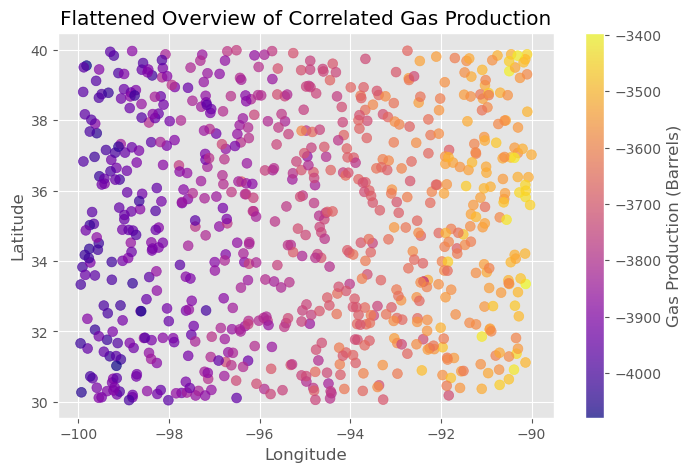

In [3]:
fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(np.array(df['Surface_Longitude']), np.array(df['Surface_Latitude']), 
                       s=50, c=np.array(df['GasProd']).flatten(), cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Flattened Overview of Correlated Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

### Coordinates, Values, and Grid Setup

In [4]:
train, test = train_test_split(df, test_size=0.25, random_state=42)

xy_gasprod_train = np.array(train[['Surface_Longitude','Surface_Latitude']].values)
v_gasprod_train = np.array(train['GasProd'].values)
x_train = xy_gasprod_train[:,0]
y_train = xy_gasprod_train[:,1]
h_train = np.array(train['True_vertical_depth'].values)

xy_gasprod_test = np.array(test[['Surface_Longitude','Surface_Latitude']].values)
v_gasprod_test = np.array(test['GasProd'].values)
x_test = xy_gasprod_test[:,0]
y_test = xy_gasprod_test[:,1]
h_test = np.array(test['True_vertical_depth'].values)

gridx_train = np.linspace(x_train.min(), x_train.max(), 100)
gridy_train = np.linspace(y_train.min(), y_train.max(), 100)
gridh_train = np.linspace(h_train.min(), h_train.max(), 100)

gridx_test = np.linspace(x_test.min(), x_test.max(), 100)
gridy_test = np.linspace(y_test.min(), y_test.max(), 100)
gridh_test = np.linspace(h_test.min(), h_test.max(), 100)

actual = v_gasprod_test

### Basic Model - Kriging

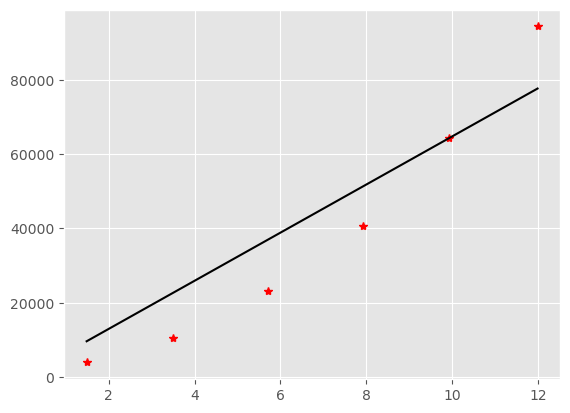


------------

RMSE: 60.523
MAE: 49.772
R2: 0.862

------------



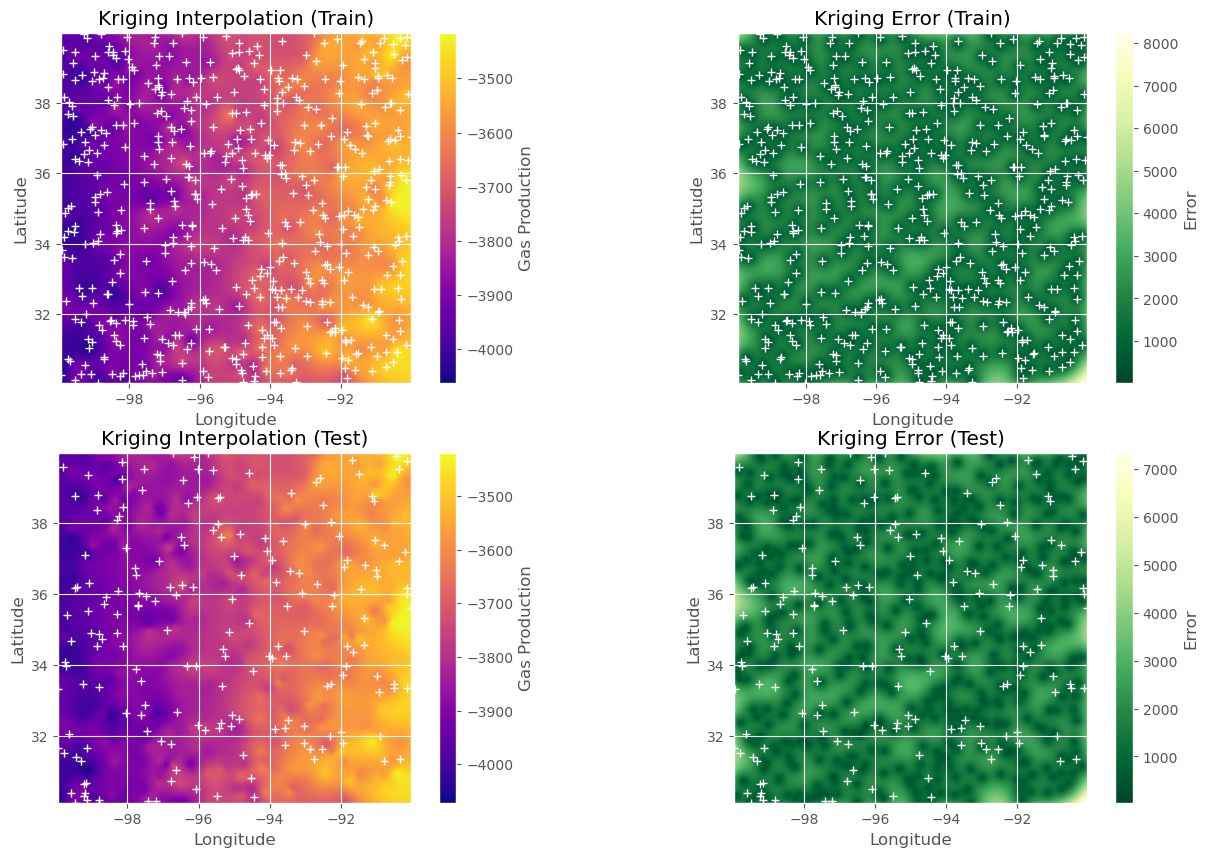

In [5]:
ok = OrdinaryKriging(
    x_train,
    y_train,
    v_gasprod_train,
    variogram_model='linear',
    verbose=False,
    enable_plotting=True )

z_train, s2_train = ok.execute("grid", gridx_train, gridy_train)
z_test, s2_test = ok.execute('grid', gridx_test, gridy_test)
pred, error = ok.execute('points', x_test, y_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(16,10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear', vmin=z_test.min(), vmax=z_test.max(),
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

### Kriging Hyperparameter Tuning

Fitting 5 folds for each of 4 candidates, totalling 20 fits
best_RMSE = -53.912
best_params =  {'method': 'ordinary', 'variogram_model': 'power'}

------------

RMSE: 54.764
MAE: 44.285
R2: 0.887

------------



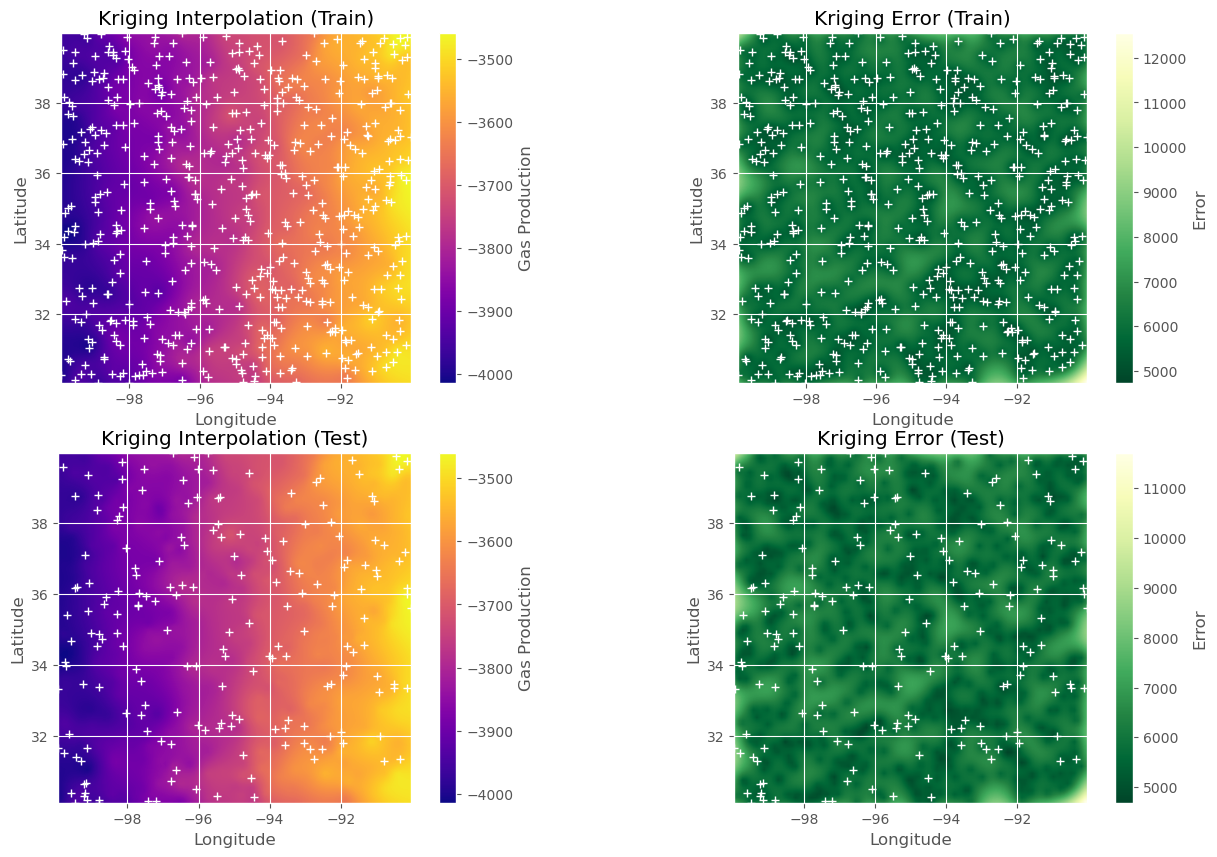

In [6]:
param_grid = {
    'method': ['ordinary'], # 'universal'],
    'variogram_model': ['linear','power','gaussian','spherical']
    # 'nlags': [4,6,8],
    # 'weight': [True,False]
}

estimator = GridSearchCV (
    Krige(), 
    param_grid, 
    cv=5, 
    scoring='neg_root_mean_squared_error',
    verbose=True, 
    return_train_score=True )

estimator.fit(X=xy_gasprod_train, y=v_gasprod_train)

if estimator.best_score_:
    print("best_RMSE = {:.3f}".format(estimator.best_score_))
    print("best_params = ", estimator.best_params_)

best_model = estimator.best_estimator_
best_model = best_model.model

z_train, s2_train = best_model.execute('grid', gridx_train, gridy_train)
z_test, s2_test = best_model.execute('grid', gridx_test, gridy_test)
pred, error = best_model.execute('points', x_test, y_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear', vmin=z_test.min(), vmax=z_test.max(),
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

### Krige Detrend

#### Method: Subtracting Actual Values from Trend Values (found from Linear Regression)

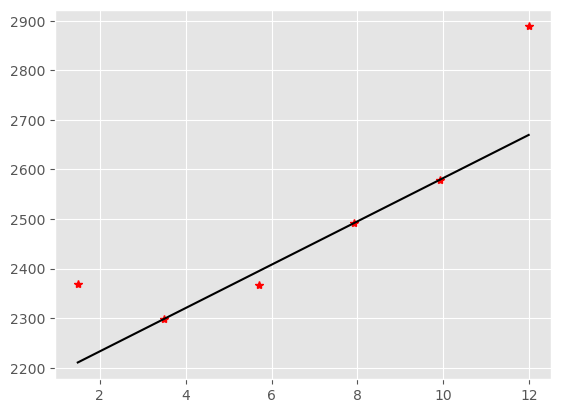


------------

RMSE: 51.239
MAE: 40.741
R2: 0.901

------------



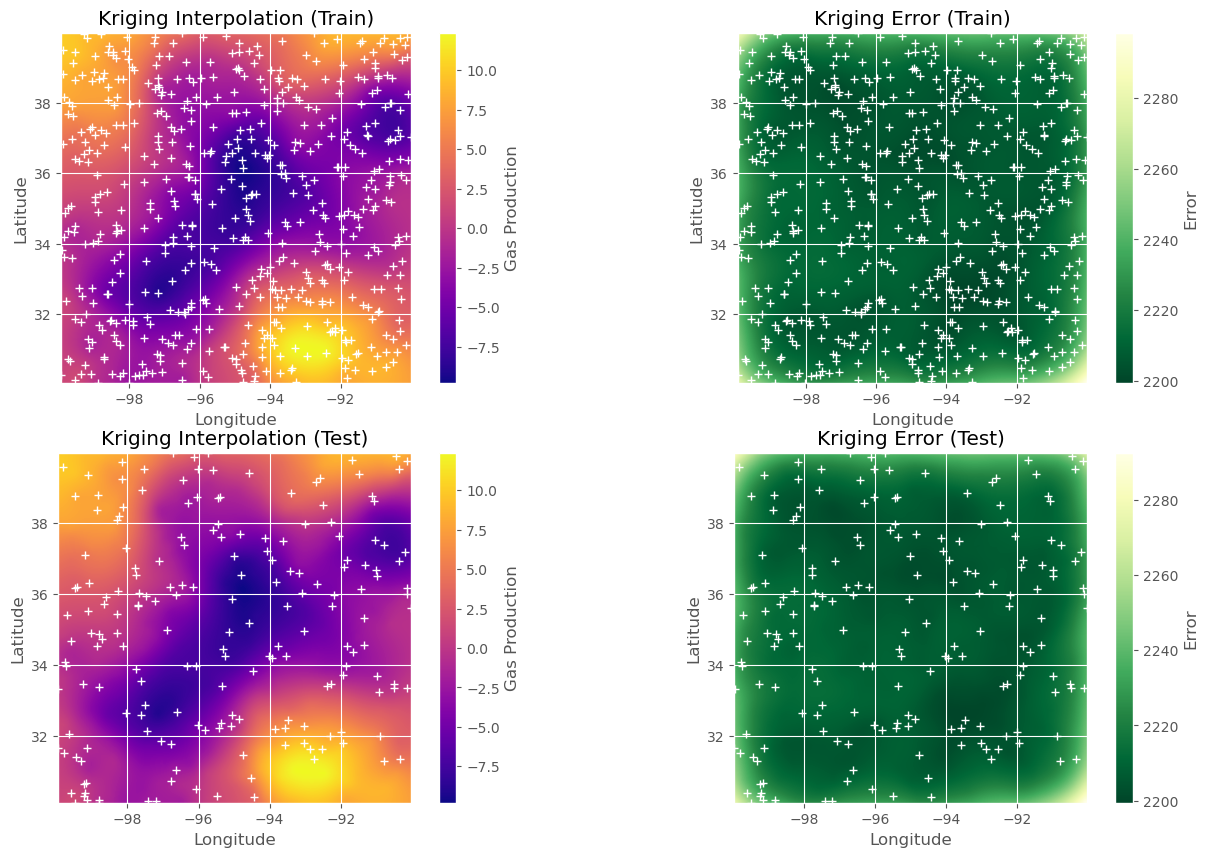

In [7]:
reg = LinearRegression().fit(xy_gasprod_train, v_gasprod_train)
trend_train = reg.predict(xy_gasprod_train)
detrended_gasprod_train = v_gasprod_train - trend_train

ok = OrdinaryKriging(
    x_train,
    y_train,
    detrended_gasprod_train,
    variogram_model='linear',
    verbose=False,
    enable_plotting=True )

z_train, s2_train = ok.execute("grid", gridx_train, gridy_train)
z_test, s2_test = ok.execute('grid', gridx_test, gridy_test)
pred, error = ok.execute('points', x_test, y_test)
pred += (reg.predict(xy_gasprod_test))

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

#### Method: Krige_Detrended GSTools Function


------------

RMSE: 50.661
MAE: 40.403
R2: 0.904

------------



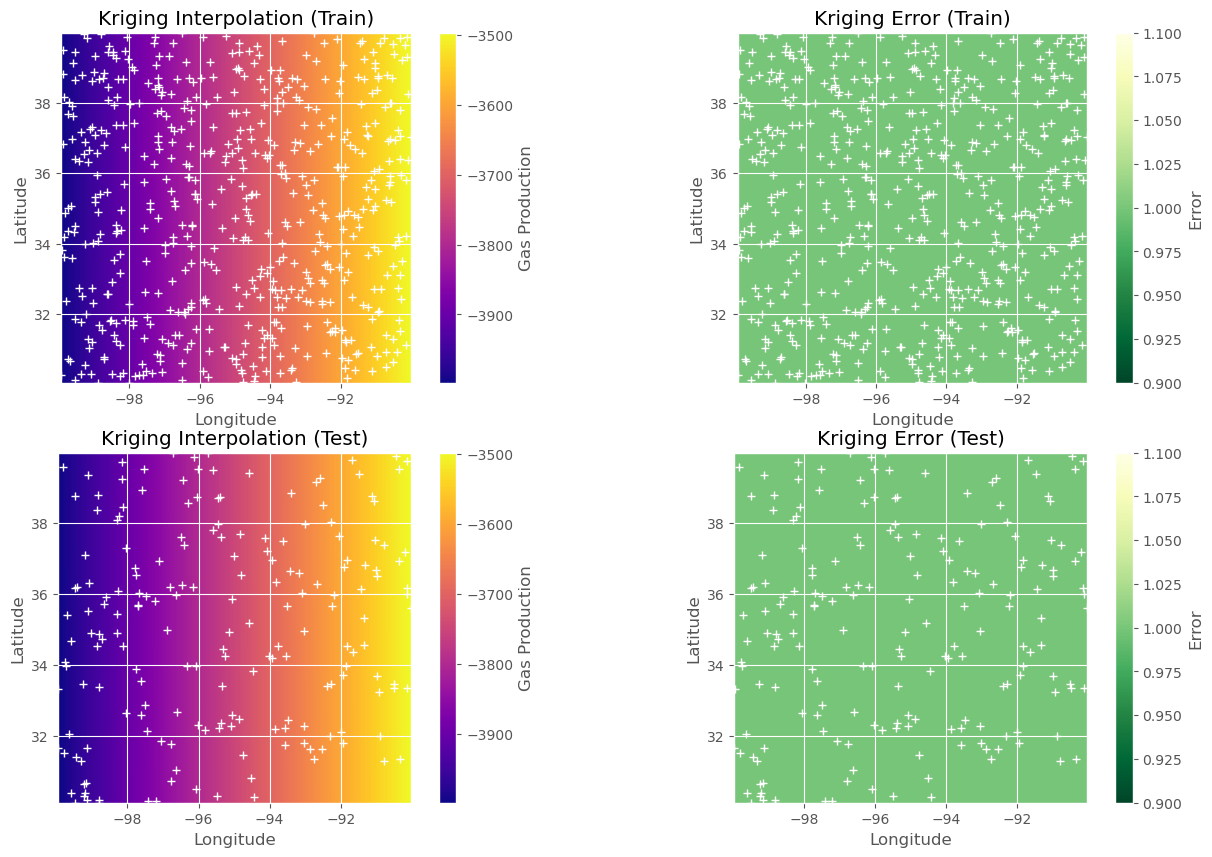

In [8]:
reg = LinearRegression()
reg.fit(xy_gasprod_train, v_gasprod_train)

def trend(x,y):
    return reg.predict(np.column_stack((x, y)))

detrended_gas = v_gasprod_train - trend(x_train, y_train)

gridx_train, gridy_train = np.meshgrid(
    np.linspace(x_train.min(), x_train.max(), 100),
    np.linspace(y_train.min(), y_train.max(), 100))
gridx_test, gridy_test = np.meshgrid(
    np.linspace(x_test.min(), x_test.max(), 100),
    np.linspace(y_test.min(), y_test.max(), 100))

model = Gaussian(
    dim=2, # 2d-array
    var=1,
    len_scale=1)

# model = Spherical(dim=2, var=0.1, len_scale=2)
# model = Exponential(dim=2, var=0.1, len_scale=2)
# model = Power(dim=2, var=0.1, len_scale=2)

krig_trend = krige.Detrended(
    model=model, 
    cond_pos=xy_gasprod_train, 
    cond_val=detrended_gas, 
    trend=trend)

z_train, s2_train = krig_trend((gridx_train.flatten(), gridy_train.flatten()))
z_test, s2_test = krig_trend((gridx_test.flatten(), gridy_test.flatten()))

z_train = z_train.reshape(100, 100)
s2_train = s2_train.reshape(100, 100)
z_test = z_test.reshape(100, 100)
s2_test = s2_test.reshape(100, 100)

z_test_pt, s2_test_pt = krig_trend((x_test, y_test))
pred = z_test_pt

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse, 3))
print("MAE:", round(mae, 3))
print("R2:", round(r2, 3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

#### Method: Krige_Detrended GSTools Function - Hyperparameter Tuning


Best Parameters:
Variance: 1.0
Length Scale: 1.0
Best RMSE: 50.66126880456034

------------

RMSE: 50.661
MAE: 40.403
R2: 0.904

------------



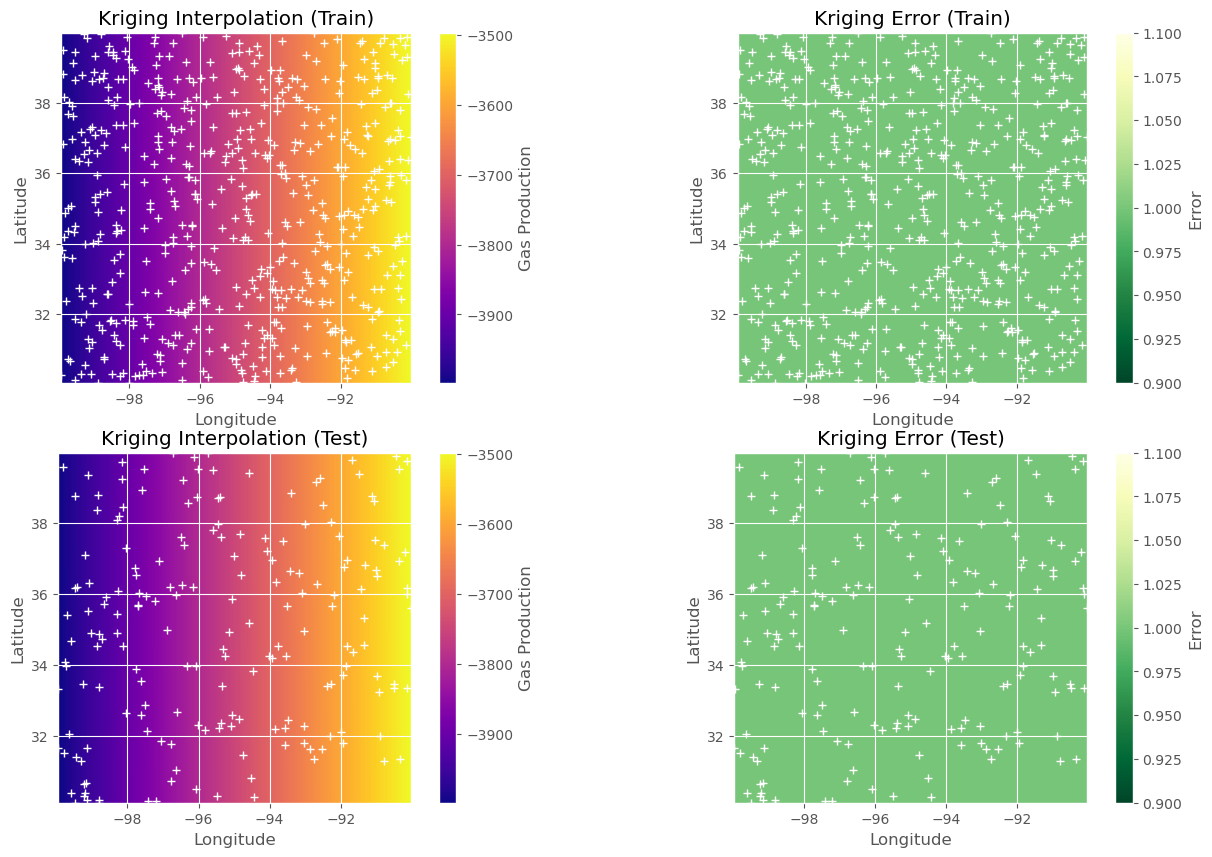

In [9]:
var_range = np.linspace(1, 100, 10)  # Variance range
len_scale_range = np.linspace(1, 50, 10)  # Length scale range

reg = LinearRegression().fit(xy_gasprod_train, v_gasprod_train)
trend_train = reg.predict(xy_gasprod_train)
detrended_gasprod_train = v_gasprod_train - trend_train

best_rmse = float('inf')
best_params = None

for var in var_range:
    for len_scale in len_scale_range:
        model = Gaussian(dim=2, var=var, len_scale=len_scale)
        krig_trend = krige.Detrended(
            model=model,
            cond_pos=xy_gasprod_train,
            cond_val=detrended_gasprod_train,
            trend=lambda x, y: reg.predict(np.column_stack((x, y))))
        
        pred_krige, error_krige = krig_trend((x_test, y_test))
        rmse = np.sqrt(mean_squared_error(v_gasprod_test, pred_krige))        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = {'var': var, 'len_scale': len_scale}

print("\nBest Parameters:")
print(f"Variance: {best_params['var']}")
print(f"Length Scale: {best_params['len_scale']}")
print(f"Best RMSE: {best_rmse}")

best_model = Gaussian(dim=2, var=best_params['var'], len_scale=best_params['len_scale'])
final_krig_trend = krige.Detrended(
    model=best_model,
    cond_pos=xy_gasprod_train,
    cond_val=detrended_gasprod_train,
    trend=lambda x, y: reg.predict(np.column_stack((x, y))))

z_train, s2_train = final_krig_trend((gridx_train.flatten(), gridy_train.flatten()))
z_test, s2_test = final_krig_trend((gridx_test.flatten(), gridy_test.flatten()))

z_train = z_train.reshape(100, 100)
s2_train = s2_train.reshape(100, 100)
z_test = z_test.reshape(100, 100)
s2_test = s2_test.reshape(100, 100)

z_test_pt, s2_test_pt = final_krig_trend((x_test, y_test))
pred = z_test_pt

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse, 3))
print("MAE:", round(mae, 3))
print("R2:", round(r2, 3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

### Kriging3D

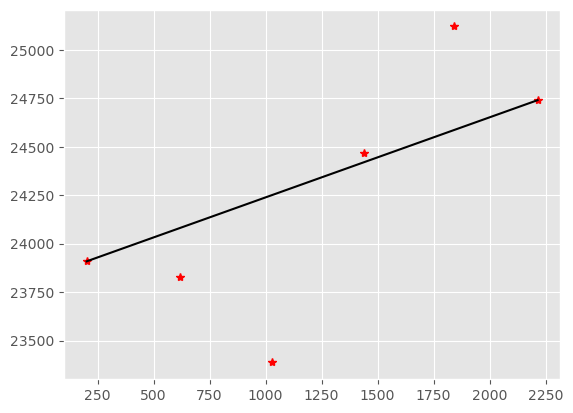


------------

RMSE: 163.707
MAE: 139.8
R2: -0.006

------------



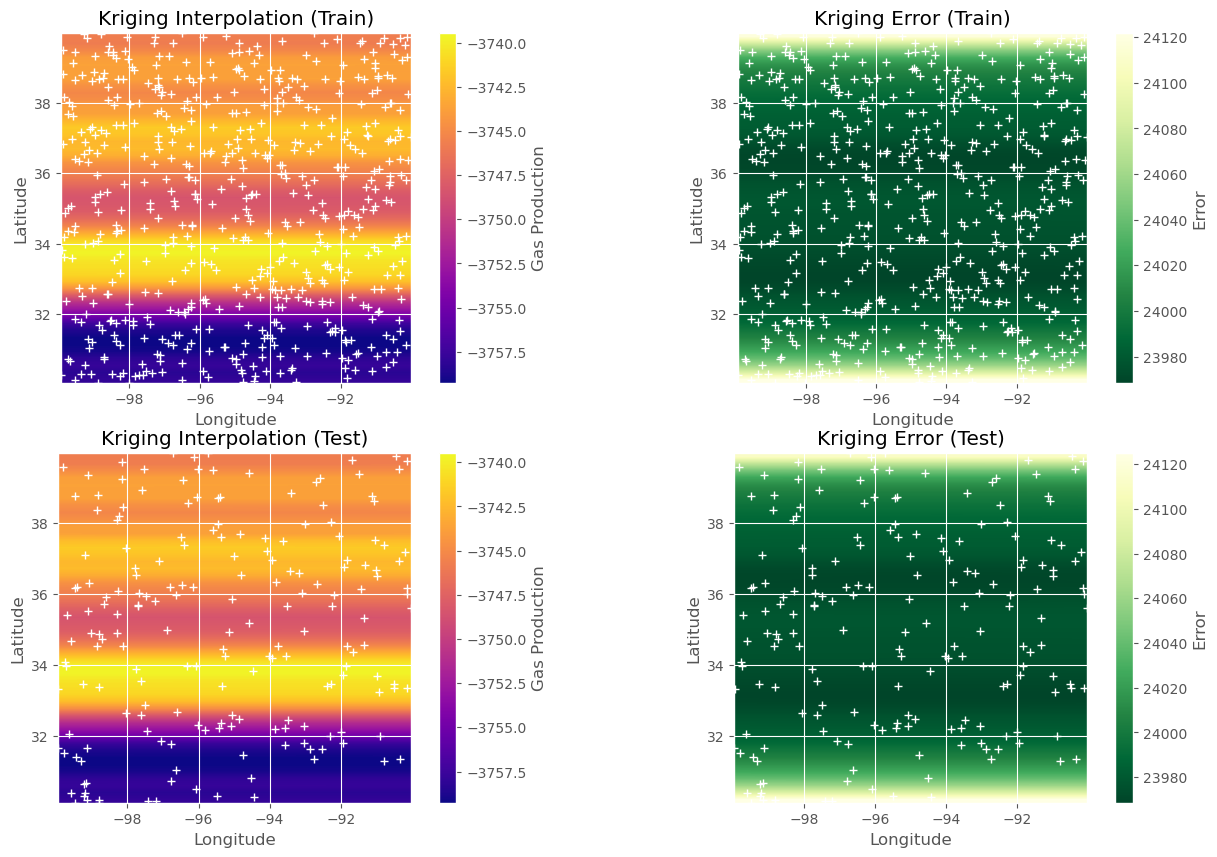

In [10]:
gridx_train = np.linspace(x_train.min(), x_train.max(), 50)
gridy_train = np.linspace(y_train.min(), y_train.max(), 50)
gridh_train = np.linspace(h_train.min(), h_train.max(), 50)

gridx_test = np.linspace(x_test.min(), x_test.max(), 50)
gridy_test = np.linspace(y_test.min(), y_test.max(), 50)
gridh_test = np.linspace(h_test.min(), h_test.max(), 50)

ok3d = OrdinaryKriging3D(
    x_train,
    y_train,
    h_train,
    v_gasprod_train,
    variogram_model='linear',
    verbose=False,
    enable_plotting=True )

z_train, s2_train = ok3d.execute("grid", gridx_train, gridy_train, gridh_train)
z_test, s2_test = ok3d.execute('grid', gridx_test, gridy_test, gridh_test)
pred, error = ok3d.execute('points', x_test, y_test, h_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(16,10))

im1 = ax1.imshow(z_train[:,:,0], cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train[:,:,0], cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test[:,:,0], cmap='plasma', interpolation='bilinear', vmin=z_test.min(), vmax=z_test.max(),
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test[:,:,0], cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

## Spatially Uncorrelated Data

### Inspect Data

In [11]:
df = df_nocorr.copy()
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   API_WellNo             750 non-null    int64  
 1   Cnty                   750 non-null    object 
 2   Well_Type              750 non-null    object 
 3   Well_Status            750 non-null    object 
 4   Producing_name         750 non-null    object 
 5   Producing_formation    750 non-null    object 
 6   Proposed_depth         750 non-null    int64  
 7   Surface_Longitude      750 non-null    float64
 8   Surface_Latitude       750 non-null    float64
 9   Bottom_hole_longitude  750 non-null    float64
 10  Bottom_hole_latitude   750 non-null    float64
 11  True_vertical_depth    750 non-null    int64  
 12  Measured_depth         750 non-null    int64  
 13  GasProd                750 non-null    float64
 14  OilProd                750 non-null    float64
 15  WaterP

API_WellNo     Cnty Well_Type Well_Status Producing_name  \
0  24012181361672  CountyC       Gas      Active         Field2   
1  89418511661948  CountyA       Gas      Active         Field3   
2  30087839072036  CountyA       Gas      Active         Field1   
3  28316077141053  CountyA       Oil    Inactive         Field1   
4  59875564545465  CountyB       Gas    Inactive         Field3   

  Producing_formation  Proposed_depth  Surface_Longitude  Surface_Latitude  \
0          Formation2            4352             -96.75             39.17   
1          Formation2            4478             -97.30             34.07   
2          Formation1            4927             -98.09             31.43   
3          Formation2            4684             -93.05             37.15   
4          Formation1            3841             -97.81             32.93   

   Bottom_hole_longitude  Bottom_hole_latitude  True_vertical_depth  \
0                 -96.25                 31.17                 2417   
1                 -90.49                 39.40                 2681   
2                 -92.68                 36.28                 1113   
3                 -94.01                 33.35                 1927   
4                 -98.44                 31.39                 2016   

   Measured_depth  GasProd  OilProd  WaterProd  Year  
0            3280   708.96   471.76        304  2005  
1            4749   880.73   678.97         27  2010  
2            3538 1,371.30   653.23        287  2010  
3            2016 1,113.93   637.84        354  2005  
4            1443   709.59   431.05        966  2010

### Data Overview Plot

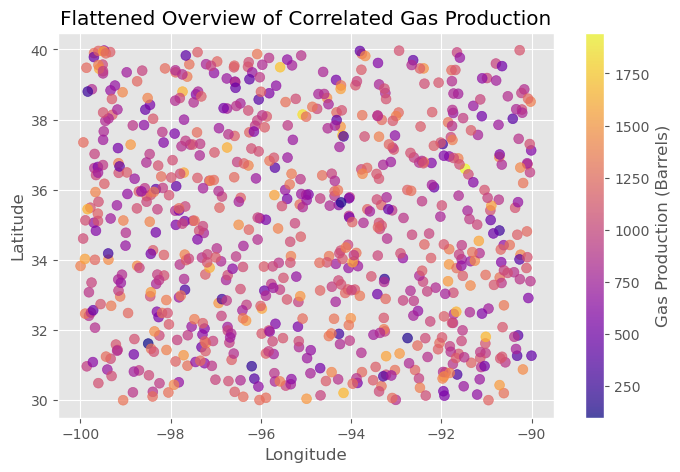

In [12]:
fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(np.array(df['Surface_Longitude']), np.array(df['Surface_Latitude']), 
                       s=50, c=np.array(df['GasProd']).flatten(), cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Flattened Overview of Correlated Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

### Coordinates, Values, and Grid Setup

In [13]:
train, test = train_test_split(df, test_size=0.25, random_state=42)

xy_gasprod_train = np.array(train[['Surface_Longitude','Surface_Latitude']].values)
v_gasprod_train = np.array(train['GasProd'].values)
x_train = xy_gasprod_train[:,0]
y_train = xy_gasprod_train[:,1]
h_train = np.array(train['True_vertical_depth'].values)

xy_gasprod_test = np.array(test[['Surface_Longitude','Surface_Latitude']].values)
v_gasprod_test = np.array(test['GasProd'].values)
x_test = xy_gasprod_test[:,0]
y_test = xy_gasprod_test[:,1]
h_test = np.array(test['True_vertical_depth'].values)

gridx_train = np.linspace(x_train.min(), x_train.max(), 100)
gridy_train = np.linspace(y_train.min(), y_train.max(), 100)
gridh_train = np.linspace(h_train.min(), h_train.max(), 100)

gridx_test = np.linspace(x_test.min(), x_test.max(), 100)
gridy_test = np.linspace(y_test.min(), y_test.max(), 100)
gridh_test = np.linspace(h_test.min(), h_test.max(), 100)

actual = v_gasprod_test

### Basic Model - Kriging

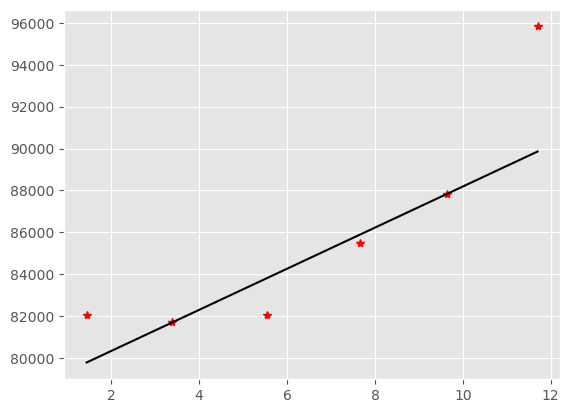


------------

RMSE: 321.719
MAE: 259.44
R2: -0.026

------------



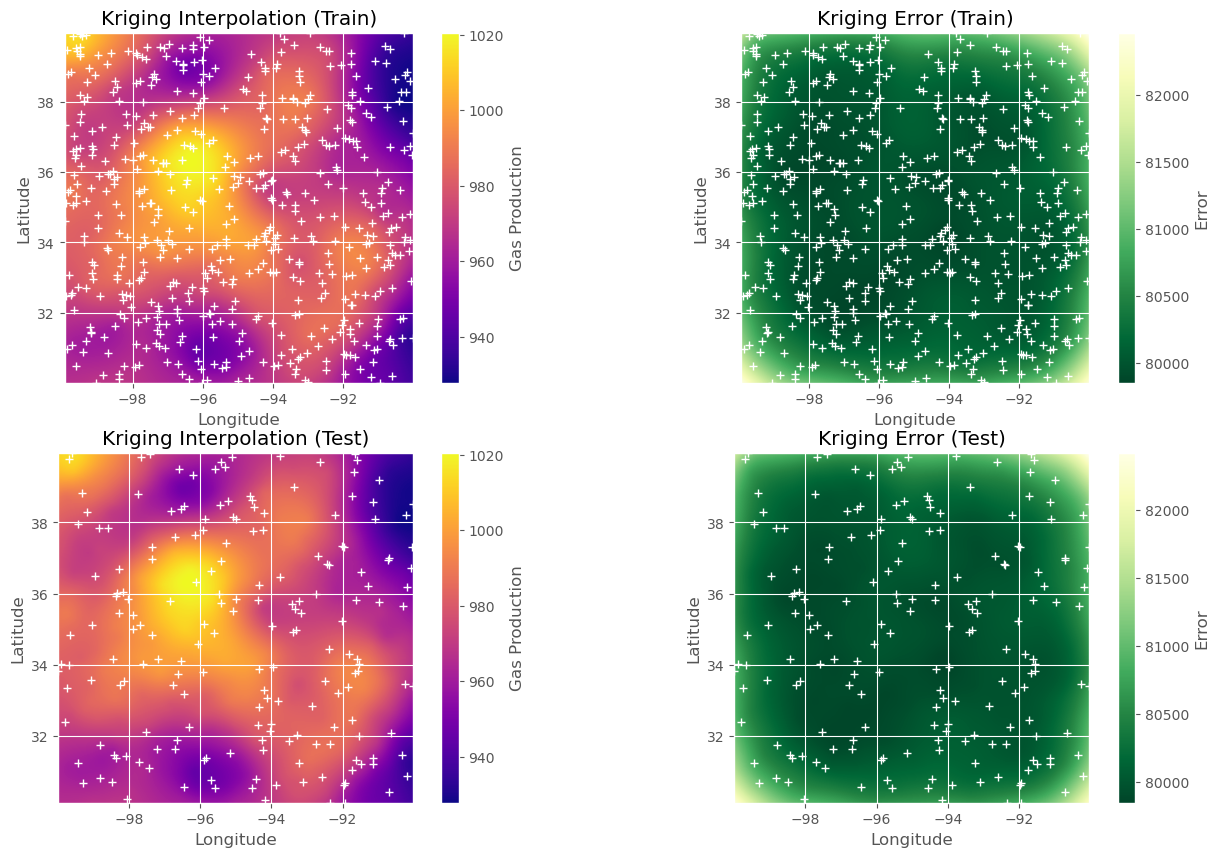

In [14]:
ok = OrdinaryKriging(
    x_train,
    y_train,
    v_gasprod_train,
    variogram_model='linear',
    verbose=False,
    enable_plotting=True )

z_train, s2_train = ok.execute("grid", gridx_train, gridy_train)
z_test, s2_test = ok.execute('grid', gridx_test, gridy_test)
pred, error = ok.execute('points', x_test, y_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(16,10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear', vmin=z_test.min(), vmax=z_test.max(),
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

### Kriging Hyperparameter Tuning

Fitting 5 folds for each of 4 candidates, totalling 20 fits
best_RMSE = -303.113
best_params =  {'method': 'ordinary', 'variogram_model': 'power'}

------------

RMSE: 321.986
MAE: 259.623
R2: -0.028

------------



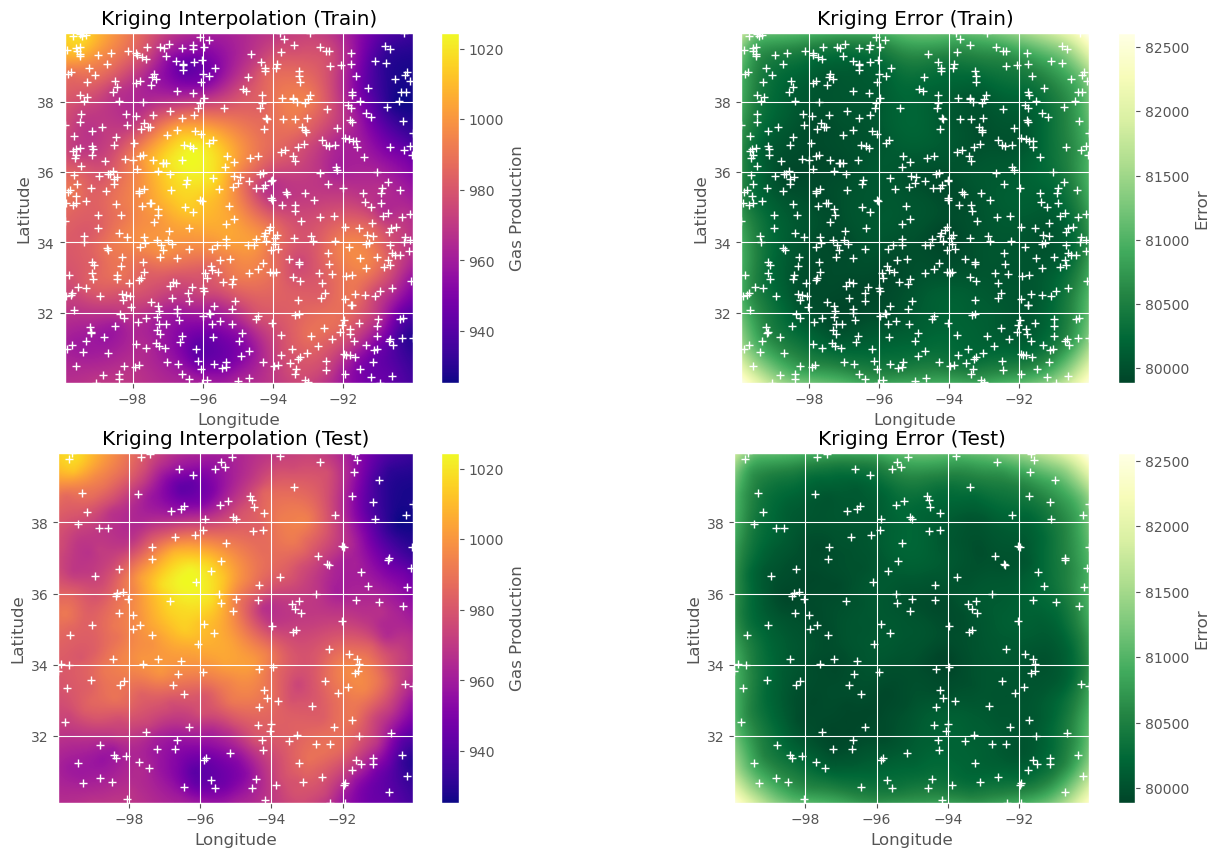

In [15]:
param_grid = {
    'method': ['ordinary'], # 'universal'],
    'variogram_model': ['linear','power','gaussian','spherical']
    # 'nlags': [4,6,8],
    # 'weight': [True,False]
}

estimator = GridSearchCV (
    Krige(), 
    param_grid, 
    cv=5, 
    scoring='neg_root_mean_squared_error',
    verbose=True, 
    return_train_score=True )

estimator.fit(X=xy_gasprod_train, y=v_gasprod_train)

if estimator.best_score_:
    print("best_RMSE = {:.3f}".format(estimator.best_score_))
    print("best_params = ", estimator.best_params_)

best_model = estimator.best_estimator_
best_model = best_model.model

z_train, s2_train = best_model.execute('grid', gridx_train, gridy_train)
z_test, s2_test = best_model.execute('grid', gridx_test, gridy_test)
pred, error = best_model.execute('points', x_test, y_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear', vmin=z_test.min(), vmax=z_test.max(),
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

### Krige Detrend

#### Method: Subtracting Actual Values from Trend Values (found from Linear Regression)

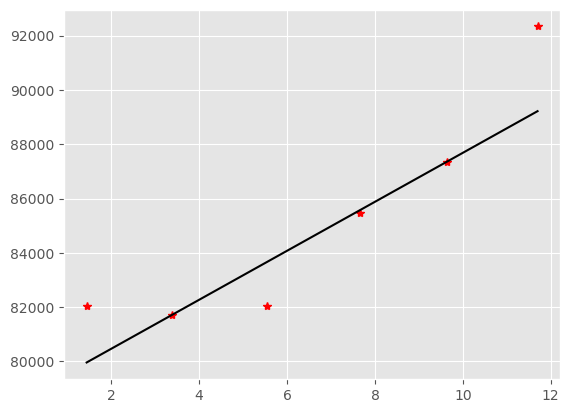


------------

RMSE: 321.612
MAE: 259.322
R2: -0.026

------------



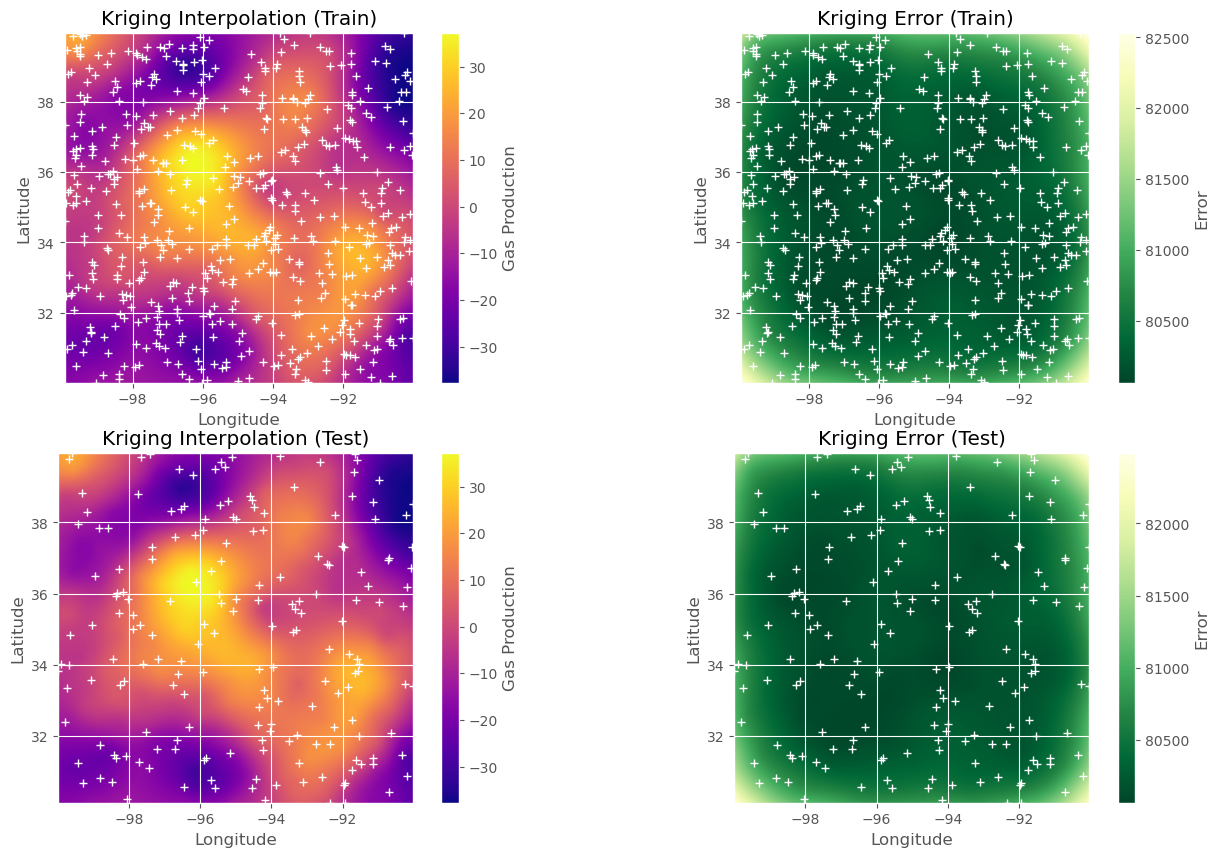

In [16]:
reg = LinearRegression().fit(xy_gasprod_train, v_gasprod_train)
trend_train = reg.predict(xy_gasprod_train)
detrended_gasprod_train = v_gasprod_train - trend_train

ok = OrdinaryKriging(
    x_train,
    y_train,
    detrended_gasprod_train,
    variogram_model='linear',
    verbose=False,
    enable_plotting=True )

z_train, s2_train = ok.execute("grid", gridx_train, gridy_train)
z_test, s2_test = ok.execute('grid', gridx_test, gridy_test)
pred, error = ok.execute('points', x_test, y_test)
pred += (reg.predict(xy_gasprod_test))

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

#### Method: Krige_Detrended GSTools Function


------------

RMSE: 319.002
MAE: 257.113
R2: -0.009

------------



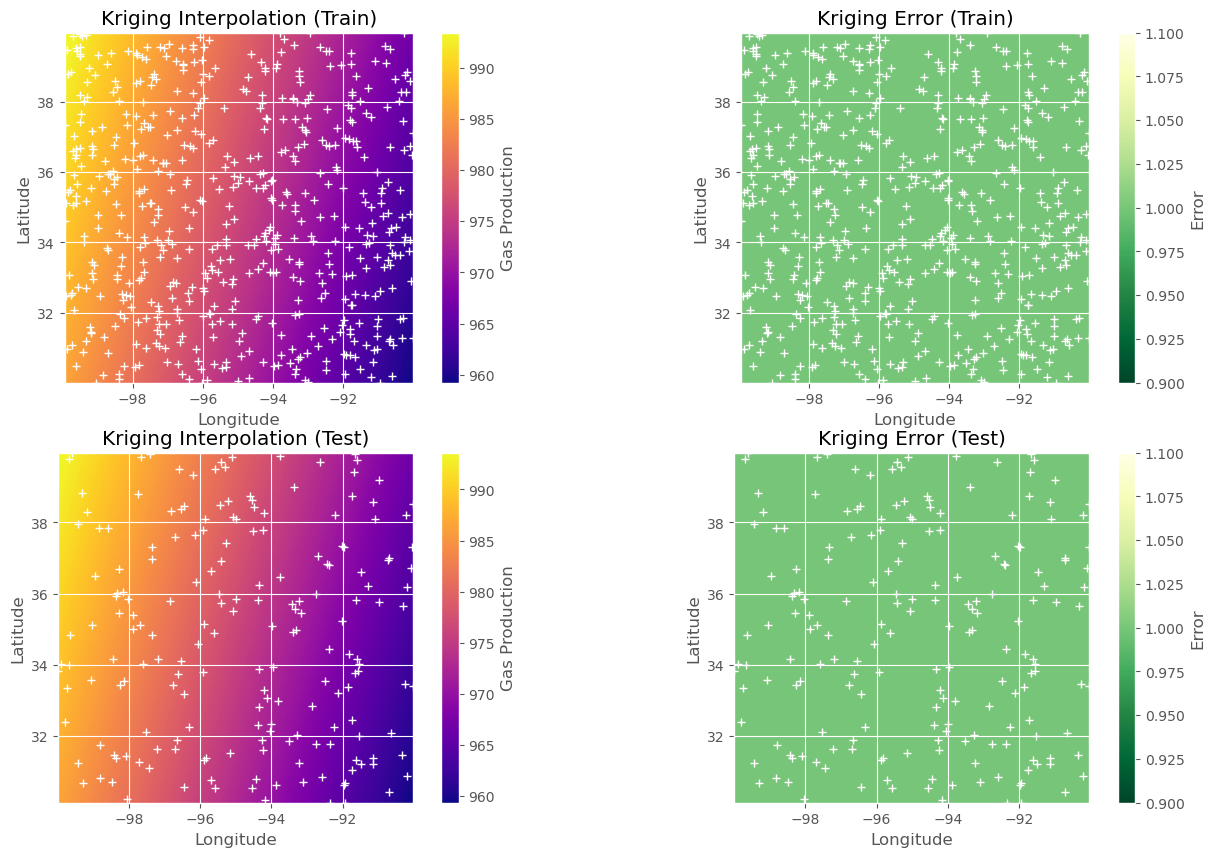

In [17]:
reg = LinearRegression()
reg.fit(xy_gasprod_train, v_gasprod_train)

def trend(x,y):
    return reg.predict(np.column_stack((x, y)))

detrended_gas = v_gasprod_train - trend(x_train, y_train)

gridx_train, gridy_train = np.meshgrid(
    np.linspace(x_train.min(), x_train.max(), 100),
    np.linspace(y_train.min(), y_train.max(), 100))
gridx_test, gridy_test = np.meshgrid(
    np.linspace(x_test.min(), x_test.max(), 100),
    np.linspace(y_test.min(), y_test.max(), 100))

model = Gaussian(
    dim=2, # 2d-array
    var=1,
    len_scale=1)

# model = Spherical(dim=2, var=0.1, len_scale=2)
# model = Exponential(dim=2, var=0.1, len_scale=2)
# model = Power(dim=2, var=0.1, len_scale=2)

krig_trend = krige.Detrended(
    model=model, 
    cond_pos=xy_gasprod_train, 
    cond_val=detrended_gas, 
    trend=trend)

z_train, s2_train = krig_trend((gridx_train.flatten(), gridy_train.flatten()))
z_test, s2_test = krig_trend((gridx_test.flatten(), gridy_test.flatten()))

z_train = z_train.reshape(100, 100)
s2_train = s2_train.reshape(100, 100)
z_test = z_test.reshape(100, 100)
s2_test = s2_test.reshape(100, 100)

z_test_pt, s2_test_pt = krig_trend((x_test, y_test))
pred = z_test_pt

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse, 3))
print("MAE:", round(mae, 3))
print("R2:", round(r2, 3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

#### Method: Krige_Detrended GSTools Function - Hyperparameter Tuning


Best Parameters:
Variance: 12.0
Length Scale: 17.333333333333336
Best RMSE: 319.0017843272327

------------

RMSE: 319.002
MAE: 257.113
R2: -0.009

------------



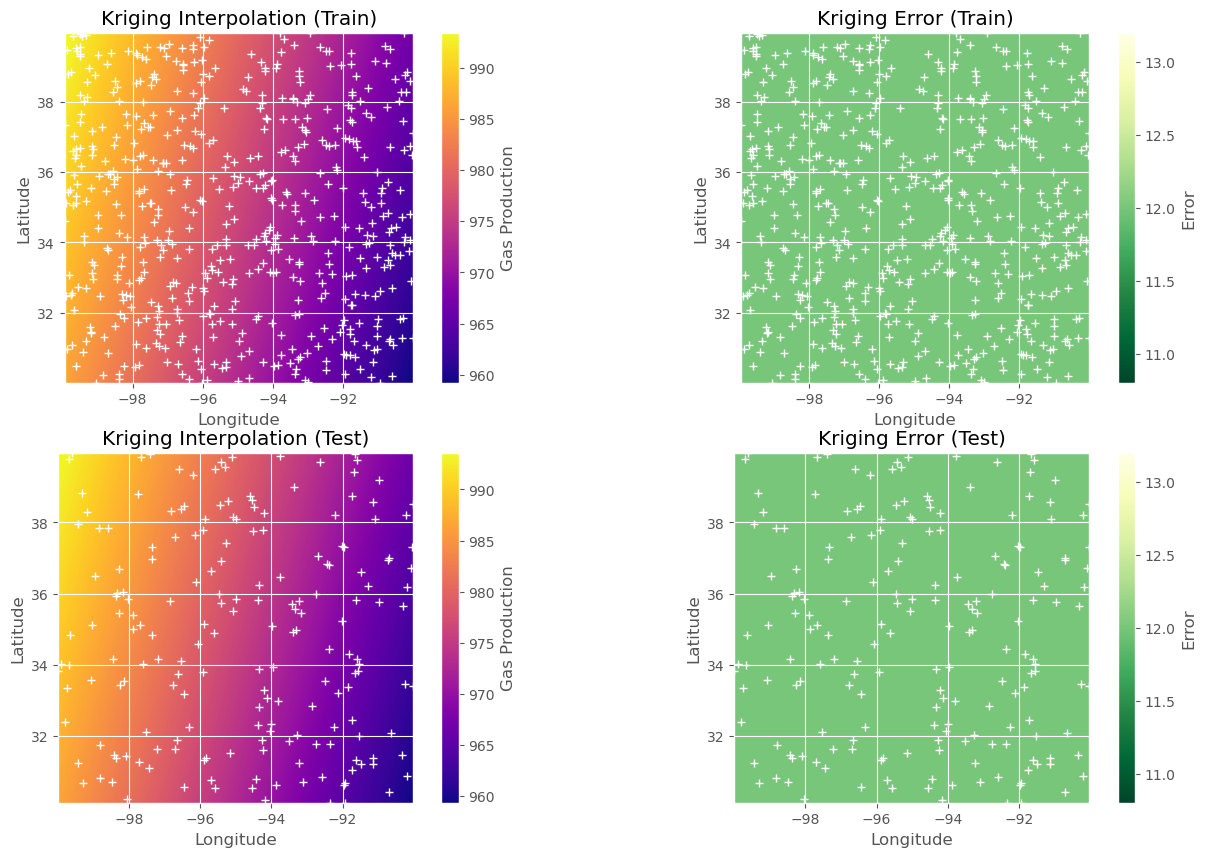

In [18]:
var_range = np.linspace(1, 100, 10)  # Variance range
len_scale_range = np.linspace(1, 50, 10)  # Length scale range

reg = LinearRegression().fit(xy_gasprod_train, v_gasprod_train)
trend_train = reg.predict(xy_gasprod_train)
detrended_gasprod_train = v_gasprod_train - trend_train

best_rmse = float('inf')
best_params = None

for var in var_range:
    for len_scale in len_scale_range:
        model = Gaussian(dim=2, var=var, len_scale=len_scale)
        krig_trend = krige.Detrended(
            model=model,
            cond_pos=xy_gasprod_train,
            cond_val=detrended_gasprod_train,
            trend=lambda x, y: reg.predict(np.column_stack((x, y))))
        
        pred_krige, error_krige = krig_trend((x_test, y_test))
        rmse = np.sqrt(mean_squared_error(v_gasprod_test, pred_krige))        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = {'var': var, 'len_scale': len_scale}

print("\nBest Parameters:")
print(f"Variance: {best_params['var']}")
print(f"Length Scale: {best_params['len_scale']}")
print(f"Best RMSE: {best_rmse}")

best_model = Gaussian(dim=2, var=best_params['var'], len_scale=best_params['len_scale'])
final_krig_trend = krige.Detrended(
    model=best_model,
    cond_pos=xy_gasprod_train,
    cond_val=detrended_gasprod_train,
    trend=lambda x, y: reg.predict(np.column_stack((x, y))))

z_train, s2_train = final_krig_trend((gridx_train.flatten(), gridy_train.flatten()))
z_test, s2_test = final_krig_trend((gridx_test.flatten(), gridy_test.flatten()))

z_train = z_train.reshape(100, 100)
s2_train = s2_train.reshape(100, 100)
z_test = z_test.reshape(100, 100)
s2_test = s2_test.reshape(100, 100)

z_test_pt, s2_test_pt = final_krig_trend((x_test, y_test))
pred = z_test_pt

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse, 3))
print("MAE:", round(mae, 3))
print("R2:", round(r2, 3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

### Kriging3D

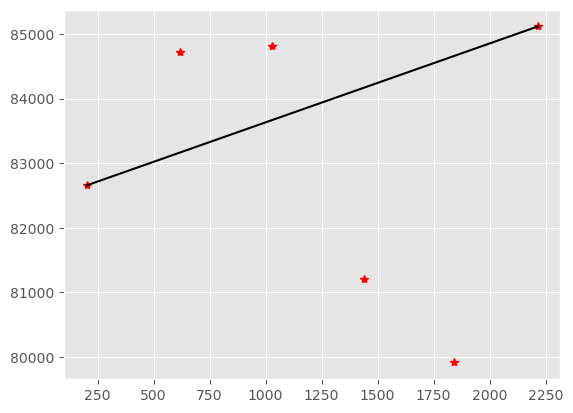


------------

RMSE: 319.103
MAE: 257.342
R2: -0.01

------------



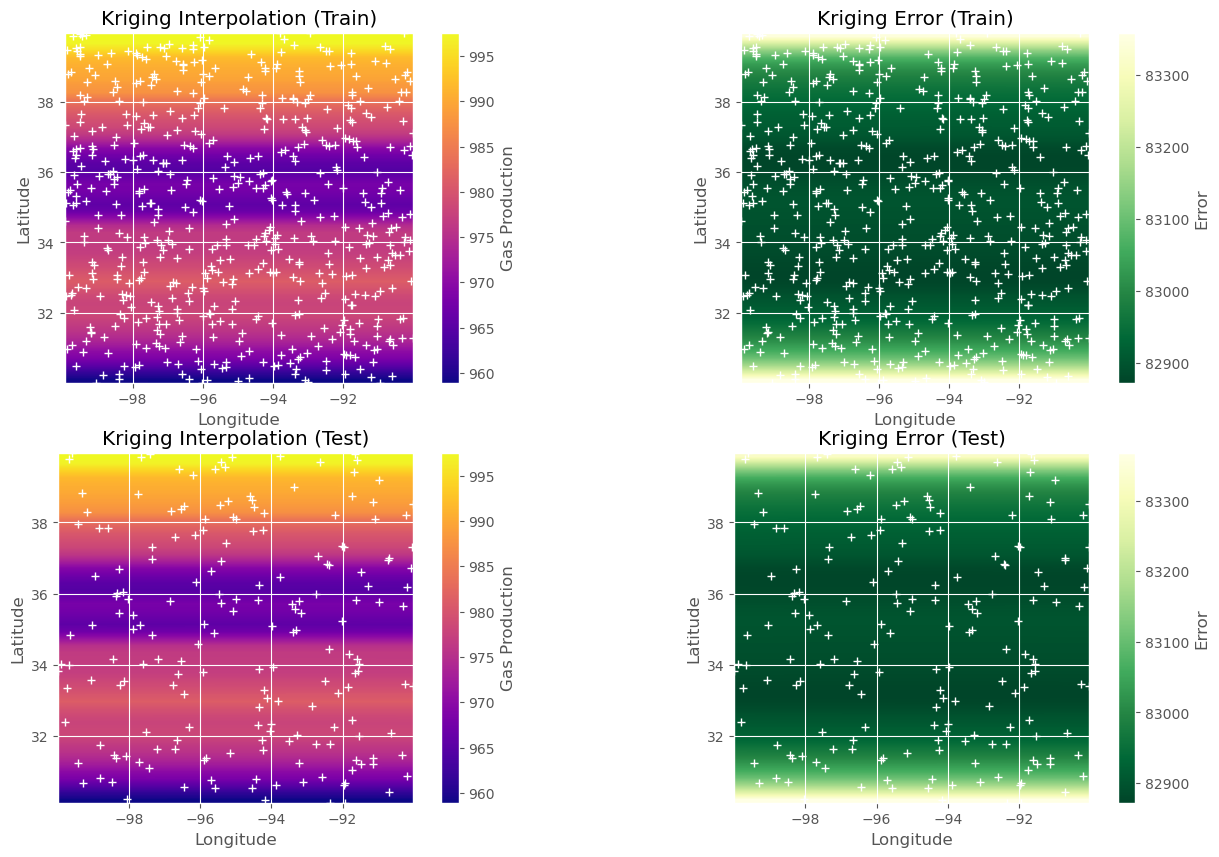

In [19]:
gridx_train = np.linspace(x_train.min(), x_train.max(), 50)
gridy_train = np.linspace(y_train.min(), y_train.max(), 50)
gridh_train = np.linspace(h_train.min(), h_train.max(), 50)

gridx_test = np.linspace(x_test.min(), x_test.max(), 50)
gridy_test = np.linspace(y_test.min(), y_test.max(), 50)
gridh_test = np.linspace(h_test.min(), h_test.max(), 50)

ok3d = OrdinaryKriging3D(
    x_train,
    y_train,
    h_train,
    v_gasprod_train,
    variogram_model='linear',
    verbose=False,
    enable_plotting=True )

z_train, s2_train = ok3d.execute("grid", gridx_train, gridy_train, gridh_train)
z_test, s2_test = ok3d.execute('grid', gridx_test, gridy_test, gridh_test)
pred, error = ok3d.execute('points', x_test, y_test, h_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(16,10))

im1 = ax1.imshow(z_train[:,:,0], cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train[:,:,0], cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test[:,:,0], cmap='plasma', interpolation='bilinear', vmin=z_test.min(), vmax=z_test.max(),
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test[:,:,0], cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

## Script

In [20]:
try:
    print('Script executed successfully.')
except:
    print('FAILED')

Script executed successfully.
